In [ ]:
%matplotlib inline

Source: [https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#exercise-computing-word-embeddings-continuous-bag-of-words](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#exercise-computing-word-embeddings-continuous-bag-of-words)

# Word Embeddings: Encoding Lexical Semantics

Word embeddings are dense vectors of real numbers, one per word in your
vocabulary. In NLP, it is almost always the case that your features are
words! But how should you represent a word in a computer? You could
store its ascii character representation, but that only tells you what
the word *is*, it doesn't say much about what it *means* (you might be
able to derive its part of speech from its affixes, or properties from
its capitalization, but not much). Even more, in what sense could you
combine these representations? We often want dense outputs from our
neural networks, where the inputs are $|V|$ dimensional, where
$V$ is our vocabulary, but often the outputs are only a few
dimensional (if we are only predicting a handful of labels, for
instance). How do we get from a massive dimensional space to a smaller
dimensional space?

How about instead of ascii representations, we use a one-hot encoding?
That is, we represent the word $w$ by
   
   
\begin{align}\overbrace{\left[ 0, 0, \dots, 1, \dots, 0, 0 \right]}^\text{|V| elements}\end{align}

where the 1 is in a location unique to $w$. Any other word will
have a 1 in some other location, and a 0 everywhere else.

There is an enormous drawback to this representation, besides just how
huge it is. It basically treats all words as independent entities with
no relation to each other. What we really want is some notion of
*similarity* between words. Why? Let's see an example.

Suppose we are building a language model. Suppose we have seen the
sentences

* The mathematician ran to the store.
* The physicist ran to the store.
* The mathematician solved the open problem.

in our training data. Now suppose we get a new sentence never before
seen in our training data:

* The physicist solved the open problem.

Our language model might do OK on this sentence, but wouldn't it be much
better if we could use the following two facts:

* We have seen  mathematician and physicist in the same role in a sentence. Somehow they
  have a semantic relation.
* We have seen mathematician in the same role  in this new unseen sentence
  as we are now seeing physicist.

and then infer that physicist is actually a good fit in the new unseen
sentence? This is what we mean by a notion of similarity: we mean
*semantic similarity*, not simply having similar orthographic
representations. It is a technique to combat the sparsity of linguistic
data, by connecting the dots between what we have seen and what we
haven't. This example of course relies on a fundamental linguistic
assumption: that words appearing in similar contexts are related to each
other semantically. This is called the `distributional
hypothesis <https://en.wikipedia.org/wiki/Distributional_semantics>`__.


# Getting Dense Word Embeddings

How can we solve this problem? That is, how could we actually encode
semantic similarity in words? Maybe we think up some semantic
attributes. For example, we see that both mathematicians and physicists
can run, so maybe we give these words a high score for the "is able to
run" semantic attribute. Think of some other attributes, and imagine
what you might score some common words on those attributes.

If each attribute is a dimension, then we might give each word a vector,
like this:

\begin{align}q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
   \overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]\end{align}

\begin{align}q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
   \overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]\end{align}

Then we can get a measure of similarity between these words by doing:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = q_\text{physicist} \cdot q_\text{mathematician}\end{align}

Although it is more common to normalize by the lengths:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
   {\| q_\text{\physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)\end{align}

Where $\phi$ is the angle between the two vectors. That way,
extremely similar words (words whose embeddings point in the same
direction) will have similarity 1. Extremely dissimilar words should
have similarity -1.


You can think of the sparse one-hot vectors from the beginning of this
section as a special case of these new vectors we have defined, where
each word basically has similarity 0, and we gave each word some unique
semantic attribute. These new vectors are *dense*, which is to say their
entries are (typically) non-zero.

But these new vectors are a big pain: you could think of thousands of
different semantic attributes that might be relevant to determining
similarity, and how on earth would you set the values of the different
attributes? Central to the idea of deep learning is that the neural
network learns representations of the features, rather than requiring
the programmer to design them herself. So why not just let the word
embeddings be parameters in our model, and then be updated during
training? This is exactly what we will do. We will have some *latent
semantic attributes* that the network can, in principle, learn. Note
that the word embeddings will probably not be interpretable. That is,
although with our hand-crafted vectors above we can see that
mathematicians and physicists are similar in that they both like coffee,
if we allow a neural network to learn the embeddings and see that both
mathematicians and physicists have a large value in the second
dimension, it is not clear what that means. They are similar in some
latent semantic dimension, but this probably has no interpretation to
us.


In summary, **word embeddings are a representation of the *semantics* of
a word, efficiently encoding semantic information that might be relevant
to the task at hand**. You can embed other things too: part of speech
tags, parse trees, anything! The idea of feature embeddings is central
to the field.


# Word Embeddings in Pytorch

Before we get to a worked example and an exercise, a few quick notes
about how to use embeddings in Pytorch and in deep learning programming
in general. Similar to how we defined a unique index for each word when
making one-hot vectors, we also need to define an index for each word
when using embeddings. These will be keys into a lookup table. That is,
embeddings are stored as a $|V| \times D$ matrix, where $D$
is the dimensionality of the embeddings, such that the word assigned
index $i$ has its embedding stored in the $i$'th row of the
matrix. In all of my code, the mapping from words to indices is a
dictionary named word\_to\_ix.

The module that allows you to use embeddings is torch.nn.Embedding,
which takes two arguments: the vocabulary size, and the dimensionality
of the embeddings.

To index into this table, you must use torch.LongTensor (since the
indices are integers, not floats).




In [ ]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward0>)


# An Example: N-Gram Language Modeling

Recall that in an n-gram language model, given a sequence of words
$w$, we want to compute

\begin{align}P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} )\end{align}

Where $w_i$ is the ith word of the sequence.

In this example, we will compute the loss function on some training
examples and update the parameters with backpropagation.




In [ ]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
[520.4473485946655, 517.883359670639, 515.3373186588287, 512.8096363544464, 510.2979497909546, 507.80289602279663, 505.3224103450775, 502.85604667663574, 500.4033172130585, 497.96352314949036]


# Exercise: Computing Word Embeddings: Continuous Bag-of-Words

The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize

\begin{align}-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)\end{align}

where $q_w$ is the embedding for word $w$.

Implement this model in Pytorch by filling in the class below. Some
tips:

* Think about which parameters you need to define.
* Make sure you know what shape each operation expects. Use .view() if you need to
  reshape.




In [ ]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        # Word embeddings
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Linear layers
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        # Obtain embeddings for the context words
        embeds = self.embeddings(inputs).sum(dim=0).view((1, -1))

        # Pass the summed embeddings through the linear layers
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)

        # Return log probabilities after softmax
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

# create your model and train.  here are some functions to help you make
# the data ready for use by your module


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


make_context_vector(data[0][0], word_to_ix)  # example

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


tensor([46, 30, 43, 10])

**Part 1 - Train your CBOW embeddings for both datasets**

Go to this Colaboratory Python Notebook (page from where we took it), create a copy of it and complete the missing code
in the exercise section - which means implementing a CBOW model in PyTorch. Then, change the code so that it takes
the Trip advisor hotel reviews text as input and produces word embeddings for the hotel reviews.
Make sure that the code is understandable by either using comments for classes and methods or by explaining the code
in text cells of the notebook.It is up to you to decide on the specific preprocessing steps (splitting sentences, tokenizing words, dealing with
punctuation, character casing, removing stopwords (perhaps!?), etc.).
1. Describe your decisions (preprocessing, class structure) in the lab report.

You will train three models:

● CBOW2 with a context width of 2 (in both directions) for the Hotel Reviews dataset.

● CBOW5 with a context width of 5 (in both directions) for the Hotel Reviews dataset.

● and CBOW2 with a context width of 2 (in both directions) for the Sci-Fi story dataset.

In order to obtain useful embeddings without training too long, we recommend an embedding size of 50 and 12-15 epochs
on the hotel reviews dataset. On the Sci-fi dataset 3 epochs are enough.

Train CBOW5 or the Hotel Reviews dataset with a context width of 5 (in both directions). Are predictions made by the
model sensitive towards the context size?

**1.Dataset Preprocessing**

**Preprocessing Scifi Dataset**

The scifi.txt dataset appears to encompass the entire text content of a book, with all sentences contained within a single paragraph and interspersed with some superfluous punctuation, it's essential to preprocess it for optimal use with the CBOW model. This involves breaking the text into individual sentences, facilitating the creation of context-target pairs for each sentence. Furthermore, each sentence should be tokenized into words, allowing for the generation of embeddings for each word. Additionally, it's crucial to remove punctuation and convert all words to lowercase to ensure vocabulary consistency. Stop words like "the", "is", "at", "which", and "on" are extremely common in the text. In the context of word embeddings, these words might not carry significant meaning on their own and might introduce noise into the learning process. So we also filter out stop words.
In the end, we filtered out low-frequency words because their limited occurrence might not provide enough contextual information to learn a good word embedding. This could result in the model assigning poor quality embeddings to these words.

In [ ]:
import re
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

# Load Sci-fi dataset
with open("scifi.txt", "r", encoding="utf-8") as f:
    scifi_txt = f.read()

# Split sentences
scifi_sents = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', scifi_txt)

# Tokenize, lowercase, stem and remove stopwords
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def tokenize(sent):
    tokens = [w.lower() for w in re.findall(r'\b\w+\b', sent)]
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    return tokens

tok_scifi = [tokenize(s) for s in scifi_sents]

# Filter low-frequency words
threshold_scifi = 10
counts_scifi = Counter([w for s in tok_scifi for w in s])

filt_scifi = [[w for w in s if counts_scifi[w] > threshold_scifi] for s in tok_scifi]
vocab_s = set([w for s in filt_scifi for w in s])


vocab_s = set([w for s in filt_scifi for w in s])
vs_s = len(vocab_s)
w2i_s = {w: i for i, w in enumerate(vocab_s)}

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Preprocessing hotel_reviews Dataset**

The tripadvisor_hotel_reviews.csv dataset appears like an Excel spreadsheet, containing 'review' and 'rating' columns. For using the CBOW model, it's better to extract the sentences from the 'review' column and discard the redundant 'rating' column. Subsequently, each review should be segmented into individual sentences and words. It's also need to eliminate any punctuation and convert all words to lowercase to ensure vocabulary consistency.The same, we also filter out stop words and low-frequency words.

In [ ]:

# Load Hotel Reviews dataset
df = pd.read_csv("tripadvisor_hotel_reviews.csv")
reviews = df['Review'].tolist()

# Split sentences
hotel_sents = [re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', r) for r in reviews]
hotel_sents = [s for sub in hotel_sents for s in sub]

# Tokenize, lowercase, stem and remove stopwords
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def tokenize(sent):
    tokens = [w.lower() for w in re.findall(r'\b\w+\b', sent)]
    tokens = [ps.stem(word) for word in tokens if word not in stop_words] # PorterStemmer seems to achieve better results
    # tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

tok_hotel = [tokenize(s) for s in hotel_sents]

# Filter low-frequency words

threshold_hotel = 10
counts_hotel = Counter([w for s in tok_hotel for w in s])
filt_hotel = [[w for w in s if counts_hotel[w] > threshold_hotel] for s in tok_hotel]

vocab_h = set([w for s in filt_hotel for w in s])
vs_h = len(vocab_h)
w2i_h = {w: i for i, w in enumerate(vocab_h)}


**2.Create context-target pairs**

In [ ]:
def create_pairs(tokenized_sents, word_to_ix, window_size):
    contexts = []
    targets = []

    for sentence in tokenized_sents:
        for idx, word in enumerate(sentence):
            if word not in word_to_ix:
                continue

            # Define the window boundaries
            start_idx = max(idx - window_size, 0)
            end_idx = min(idx + window_size + 1, len(sentence))

            context = [sentence[i] for i in range(start_idx, end_idx) if i != idx and sentence[i] in word_to_ix]

            if len(context) == 2 * window_size:
                contexts.append([word_to_ix[w] for w in context])
                targets.append(word_to_ix[word])

    return contexts, targets

ctx_h2, tgt_h2 = create_pairs(tok_hotel, w2i_h, 2)
ctx_h5, tgt_h5 = create_pairs(tok_hotel, w2i_h, 5)
ctx_s2, tgt_s2 = create_pairs(tok_scifi, w2i_s, 2)

print(ctx_h2[0])
print(len(ctx_h2))
print(len(tgt_h2))
print(type(ctx_h2))
print(type(ctx_h2[0]))
print(type(ctx_h2[0][0]))
print(type(tgt_h2))
print(type(tgt_h2[0]))



[667, 3926, 4891, 4941]
788500
788500
<class 'list'>
<class 'list'>
<class 'int'>
<class 'list'>
<class 'int'>


**3.Bulid class "CBOW"**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define the CBOW model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).sum(dim=1)
        out = self.linear(embeds)
        log_probs = F.log_softmax(out, dim=1)

        return log_probs


**4.Function Training**

In [ ]:
# Training function

import torch
from torch.utils.data import DataLoader, TensorDataset

def train(model, ctx, tgt, w2i, epochs=12, lr=0.001, bs=512):
    # Use GPU or CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training with {device}")

    model.to(device)
    loss_fn = nn.NLLLoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    losses = []

    data = TensorDataset(torch.tensor(ctx, dtype=torch.long, device=device), torch.tensor(tgt, dtype=torch.long, device=device))
    loader = DataLoader(data, batch_size=bs, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for c_idxs, t_idxs in loader:
            opt.zero_grad()
            log_probs = model(c_idxs)
            loss = loss_fn(log_probs, t_idxs)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        losses.append(total_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")
    return model, losses

**5.Model training**

In [ ]:
# Hotel dataset, CBOW2

model_h2 = CBOW(len(w2i_h), 50)
model_h2, losses_h2 = train(model_h2, ctx_h2, tgt_h2, w2i_h)

Training with cuda:0
Epoch 1/12, Loss: 10863.398180007935
Epoch 2/12, Loss: 9666.474066257477
Epoch 3/12, Loss: 9332.779833316803
Epoch 4/12, Loss: 9147.125990390778
Epoch 5/12, Loss: 9021.802947044373
Epoch 6/12, Loss: 8930.165895462036
Epoch 7/12, Loss: 8856.14604139328
Epoch 8/12, Loss: 8794.637266159058
Epoch 9/12, Loss: 8743.163204669952
Epoch 10/12, Loss: 8696.777223587036
Epoch 11/12, Loss: 8656.515926361084
Epoch 12/12, Loss: 8619.067859172821


In [ ]:
# Hotel dataset, CBOW5


model_h5 = CBOW(len(w2i_h), 50)
model_h5, losses_h5 = train(model_h5, ctx_h5, tgt_h5, w2i_h)


Training with cuda:0
Epoch 1/12, Loss: 8252.181352615356
Epoch 2/12, Loss: 7255.899592399597
Epoch 3/12, Loss: 7023.866575241089
Epoch 4/12, Loss: 6897.51720905304
Epoch 5/12, Loss: 6812.390585422516
Epoch 6/12, Loss: 6749.638800621033
Epoch 7/12, Loss: 6697.744713306427
Epoch 8/12, Loss: 6654.669141292572
Epoch 9/12, Loss: 6617.237387180328
Epoch 10/12, Loss: 6583.398156642914
Epoch 11/12, Loss: 6553.1334137916565
Epoch 12/12, Loss: 6525.623785972595


In [ ]:
# Training function - Scifif dataset function, use 3 epochs.

import torch
from torch.utils.data import DataLoader, TensorDataset

def train_scifi(model, ctx, tgt, w2i, epochs=3, lr=0.001, bs=512):
    loss_fn = nn.NLLLoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    losses = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    data = TensorDataset(torch.tensor(ctx, dtype=torch.long, device=device), torch.tensor(tgt, dtype=torch.long, device=device))
    loader = DataLoader(data, batch_size=bs, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for c_idxs, t_idxs in loader:
            opt.zero_grad()
            log_probs = model(c_idxs)
            loss = loss_fn(log_probs, t_idxs)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        losses.append(total_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")
    return model, losses


# Scifi dataset, CBOW2

model_s2 = CBOW(len(w2i_s), 50)
model_s2, losses_s2 = train_scifi(model_s2, ctx_s2, tgt_s2, w2i_s)

Epoch 1/3, Loss: 28534.90088033676
Epoch 2/3, Loss: 26369.943466186523
Epoch 3/3, Loss: 25763.535341739655


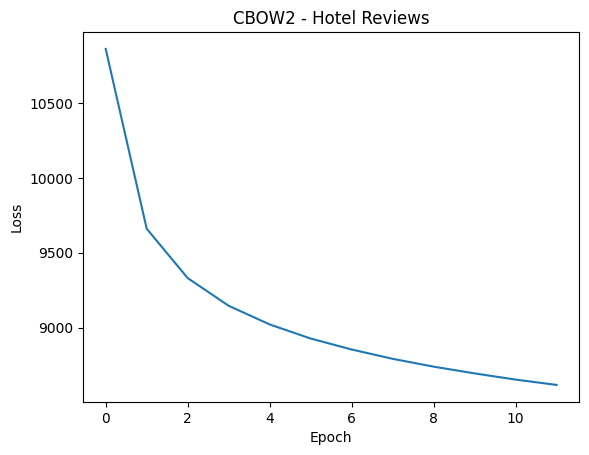

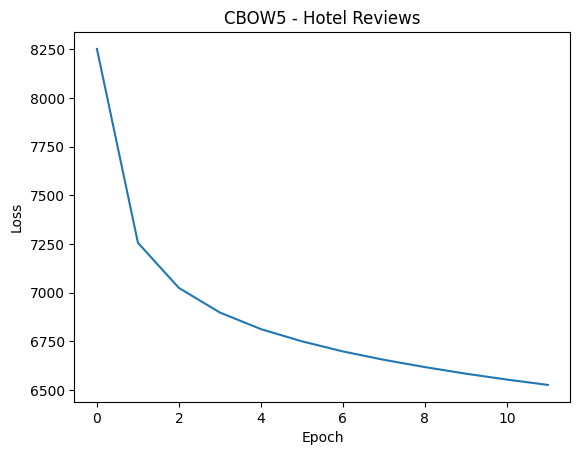

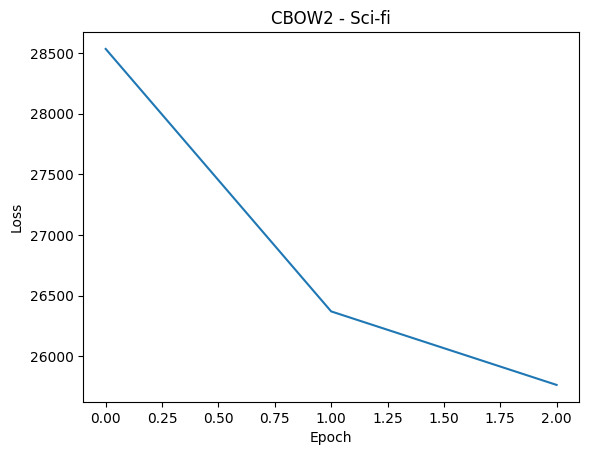

In [ ]:
import matplotlib.pyplot as plt

# Plotting the losses
def plot_losses(losses, title):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

# Using the function to plot losses for the trained models
plot_losses(losses_h2, 'CBOW2 - Hotel Reviews')
plot_losses(losses_h5, 'CBOW5 - Hotel Reviews')
plot_losses(losses_s2, 'CBOW2 - Sci-fi')


**Part 2 - Test your embeddings**

Word embeddings are not easy to evaluate automatically without suitable test sets. For this exercise, we inspect them
manually to get a feel for whether they capture what we think they should capture. Computing the nearest neighbours (see
below) for a word allows us to get an intuition of the semantic vector space. Do the following for CBOW2 and, optionally,
for CBOW5:
2. For the hotel reviews dataset, choose 3 nouns, 3 verbs, and 3 adjectives. Make sure that some
nouns/verbs/adjectives occur frequently in the corpus and that others are rare. For each of the 9 chosen words,
retrieve the 5 closest words according to your trained CBOW2 model. List them in your report and comment on
the performance of your model: do the neighbours the model provides make sense? Discuss.
3. Repeat what you did in 2. for the Sci-fi dataset.
4. How does the quality of the hotel review-based embeddings compare with the Sci-fi-based embeddings?
Elaborate.
5. Choose 2 words and retrieve their 5 closest neighbours according to hotel review-based embeddings and the
Sci-fi-based embeddings. Do they have different neighbours? If yes, can you reason why?
6. What are the differences between CBOW2 and CBOW5 ? Can you "describe" them?

In [ ]:
import pandas as pd

# Convert frequency
h_freqs = Counter([w for s in filt_hotel for w in s])
s_freqs = Counter([w for s in filt_scifi for w in s])

# Sort frequency
h_df = pd.DataFrame(list(h_freqs.items()), columns=["Word", "Freq"]).sort_values(by="Freq", ascending=False)
s_df = pd.DataFrame(list(s_freqs.items()), columns=["Word", "Freq"]).sort_values(by="Freq", ascending=False)

# Common words
merged_df = pd.merge(h_df, s_df, on="Word", how="inner", suffixes=('_hotel', '_scifi'))

# Save
h_df.to_csv("hotel_freqs.csv", index=False)
s_df.to_csv("scifi_freqs.csv", index=False)
merged_df.to_csv("common_freqs.csv", index=False)


In [ ]:
import torch.nn.functional as F

def nearest(word, emb, idx_map, k=5):
    # Check words
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if word not in idx_map:
        return [f"{word} not in vocabulary"]

    # Fetch the embedding
    word_vec = emb(torch.tensor(idx_map[word], device=device)).unsqueeze(0)

    # Cosine similarity
    sims = F.cosine_similarity(word_vec, emb.weight)

    _, top_idxs = sims.topk(k + 1)
    neighbors = [list(idx_map.keys())[list(idx_map.values()).index(i)] for i in top_idxs if i != idx_map[word]]

    return neighbors


In [ ]:
# 2. For the hotel reviews dataset, choose 3 nouns, 3 verbs, and 3 adjectives. Make sure that some
# nouns/verbs/adjectives occur frequently in the corpus and that others are rare. For each of the 9 chosen words,
# retrieve the 5 closest words according to your trained CBOW2 model. List them in your report and comment on
# the performance of your model: do the neighbours the model provides make sense? Discuss.

# Choose words，Arrangement: nouns, verbs, adjectives. For each distinct word category,
# three words were chosen, representing low, medium, and high occurrence frequencies.

hotel_w = ['network', 'souvenir', 'floor', 'stronger', 'new', 'nice', 'vote', 'stop', 'help']

# 3. Repeat what you did in 2. for the Sci-fi dataset.
scifi_w = ['skylight', 'fish', 'space', 'homey', 'wild', 'good', 'embed', 'threw', 'watch']


# 4. How does the quality of the hotel review-based embeddings compare with the Sci-fi-based embeddings?
# Elaborate. ---> Report
print("Hotel Reviews Neighbors (CBOW2):")
for w in hotel_w:
    print(f"{w}: {nearest(w, model_h2.embeddings, w2i_h)}")

print("\nHotel Reviews Neighbors (CBOW5):")
for w in hotel_w:
    print(f"{w}: {nearest(w, model_h5.embeddings, w2i_h)}")

print("\nSci-fi Neighbors (CBOW2):")
for w in scifi_w:
    print(f"{w}: {nearest(w, model_s2.embeddings, w2i_s)}")


# 5. Choose 2 words and retrieve their 5 closest neighbours according to hotel review-based embeddings and the
# Sci-fi-based embeddings. Do they have different neighbours? If yes, can you reason why?---> Report
# Compare two words in all embeddings

compare_w = ['area', 'star']
print("\nComparison:")
for w in compare_w:
    print(f"Hotel (CBOW2) {w}: {nearest(w, model_h2.embeddings, w2i_h)}")
    print(f"Hotel (CBOW5) {w}: {nearest(w, model_h5.embeddings, w2i_h)}")
    print(f"Sci-fi (CBOW2) {w}: {nearest(w, model_s2.embeddings, w2i_s)}\n")


Hotel Reviews Neighbors (CBOW2):
network: ['justifi', 'timeshar', 'pablo', 'dvd', 'hudson']
souvenir: ['calamari', 'da', 'shell', 'forev', 'scottsdal']
floor: ['komaneka', 'infin', 'disgust', 'bang', 'blare']
stronger: ['stuff', 'goer', 'swimsuit', 'forth', 'hawker']
new: ['neck', 'door', 'usual', 'exactli', 'gotten']
nice: ['wonder', 'terrif', 'love', 'suffici', 'well']
vote: ['vote not in vocabulary']
stop: ['right', 'rail', 'deliveri', 'mcdonald', 'hop']
help: ['useless', 'insist', 'doorman', 'outgo', 'contact']

Hotel Reviews Neighbors (CBOW5):
network: ['dc', 'confer', 'hurt', 'qt', 'trueli']
souvenir: ['stuff', 'lip', 'deliveri', 'isnt', 'rear']
floor: ['alloc', 'suntec', 'climb', 'regenc', 'imag']
stronger: ['fat', 'walt', 'linen', 'embarrass', 'reccomend']
new: ['rout', 'oceanfront', 'overheard', 'plush', 'oil']
nice: ['great', 'went', 'warm', 'soul', 'germain']
vote: ['vote not in vocabulary']
stop: ['swamp', 'stuck', 'sheet', 'tram', 'handi']
help: ['russian', 'calamari', 'ac

Hotel CBOW2:


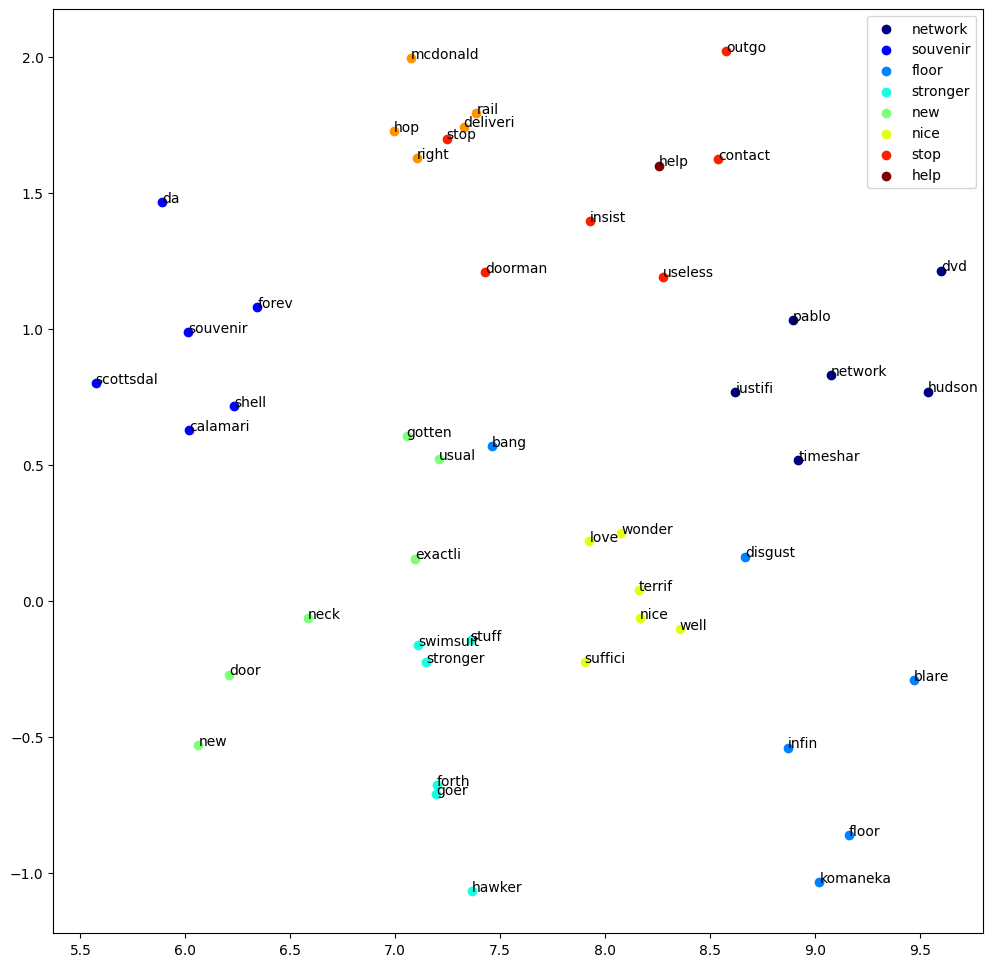

Hotel CBOW5:


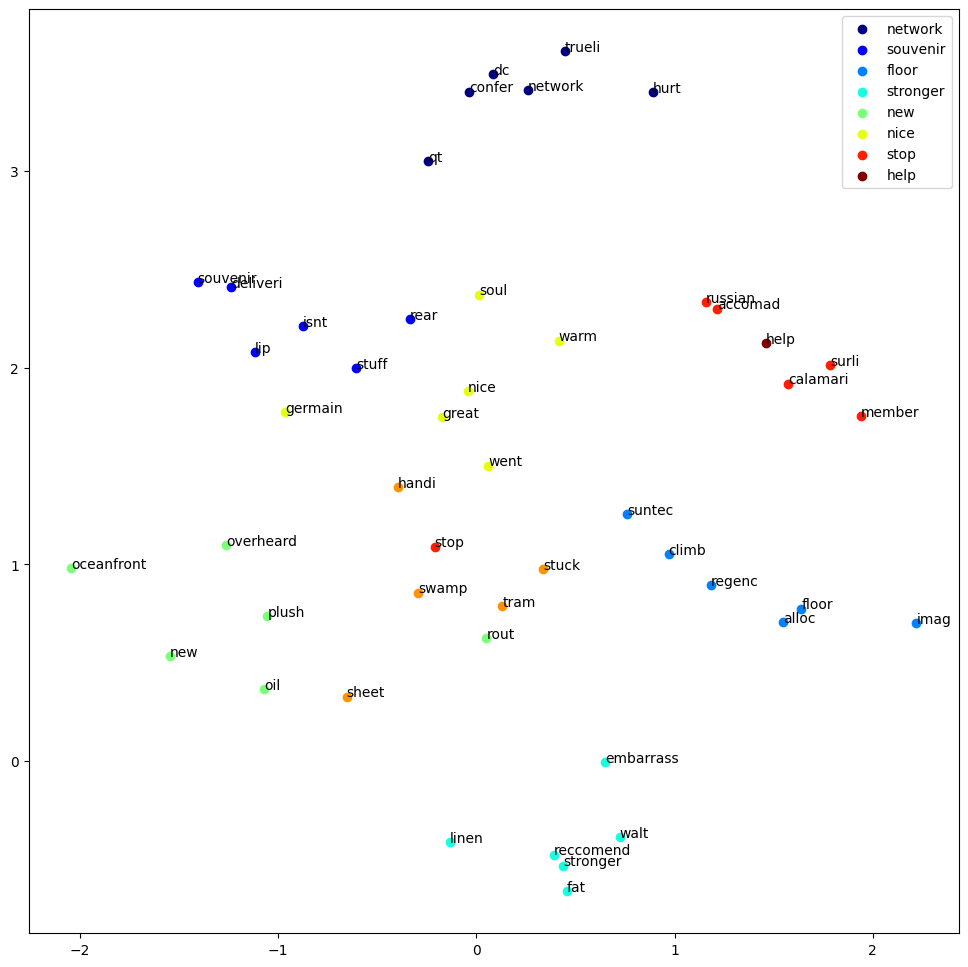

Sci-fi CBOW2:


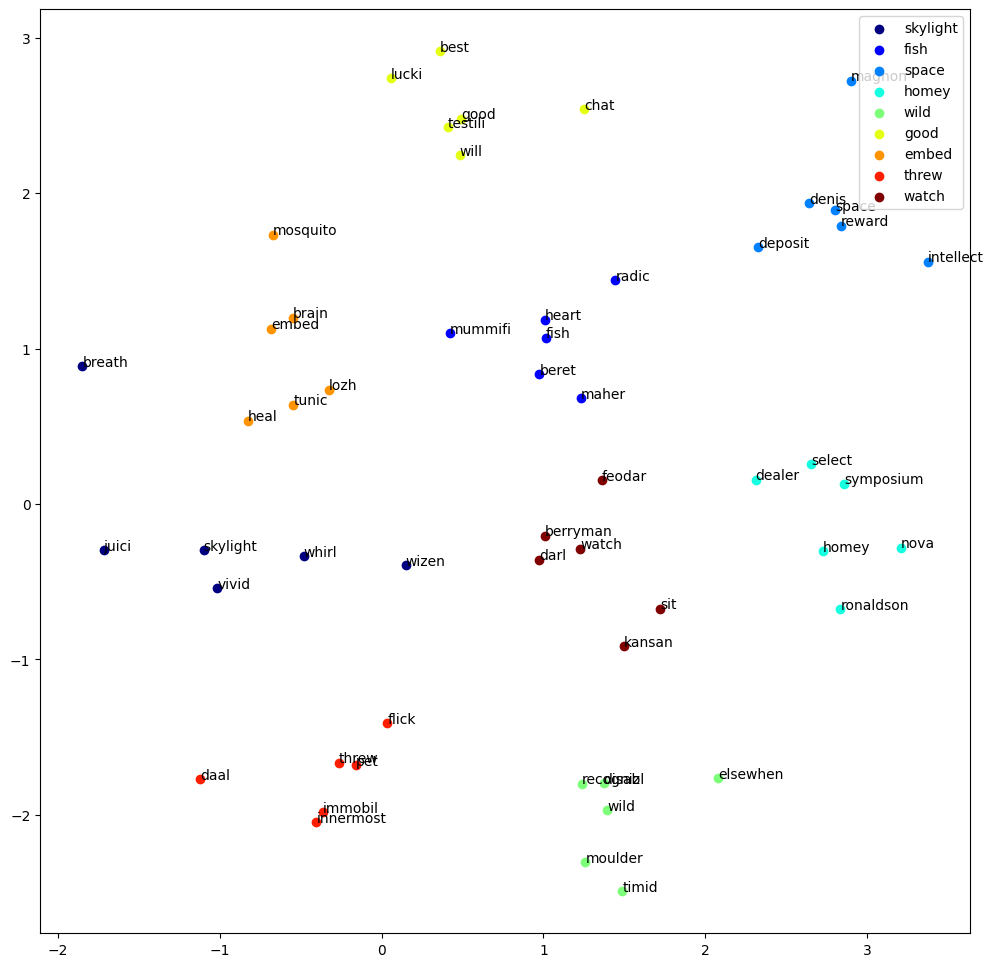

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


def visualize_words(words, model, w2i_dict):

    # Prepare embeddings and labels
    embeds = []
    labels = []
    colors = plt.cm.jet(np.linspace(0, 1, len(words)))

    word_colors = {}
    for idx, word in enumerate(words):
        word_colors[word] = colors[idx]

    for word in words:
      if word in w2i_dict:  # Check if the word is in the vocabulary
        similar = nearest(word, model.embeddings, w2i_dict)[:5]
        labels.append(word)
        embeds.append(model.embeddings.weight[w2i_dict[word]].cpu().detach().numpy())
        for sim in similar:
            labels.append(sim)
            embeds.append(model.embeddings.weight[w2i_dict[sim]].cpu().detach().numpy())

    embeds = np.array(embeds)

    # Reduce dimensions
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeds)

    # Plot
    plt.figure(figsize=(12, 12))
    for i, label in enumerate(labels):
        if label in word_colors:
            plt.scatter(reduced[i, 0], reduced[i, 1], color=word_colors[label], label=label if label in words else "")
        else:
            plt.scatter(reduced[i, 0], reduced[i, 1], color=word_colors[words[i // 6]])
        plt.annotate(label, (reduced[i, 0], reduced[i, 1]))

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

# Visualization words
print("Hotel CBOW2:")
visualize_words(hotel_w, model_h2, w2i_h)

print("Hotel CBOW5:")
visualize_words(hotel_w, model_h5, w2i_h)

print("Sci-fi CBOW2:")
visualize_words(scifi_w, model_s2, w2i_s)


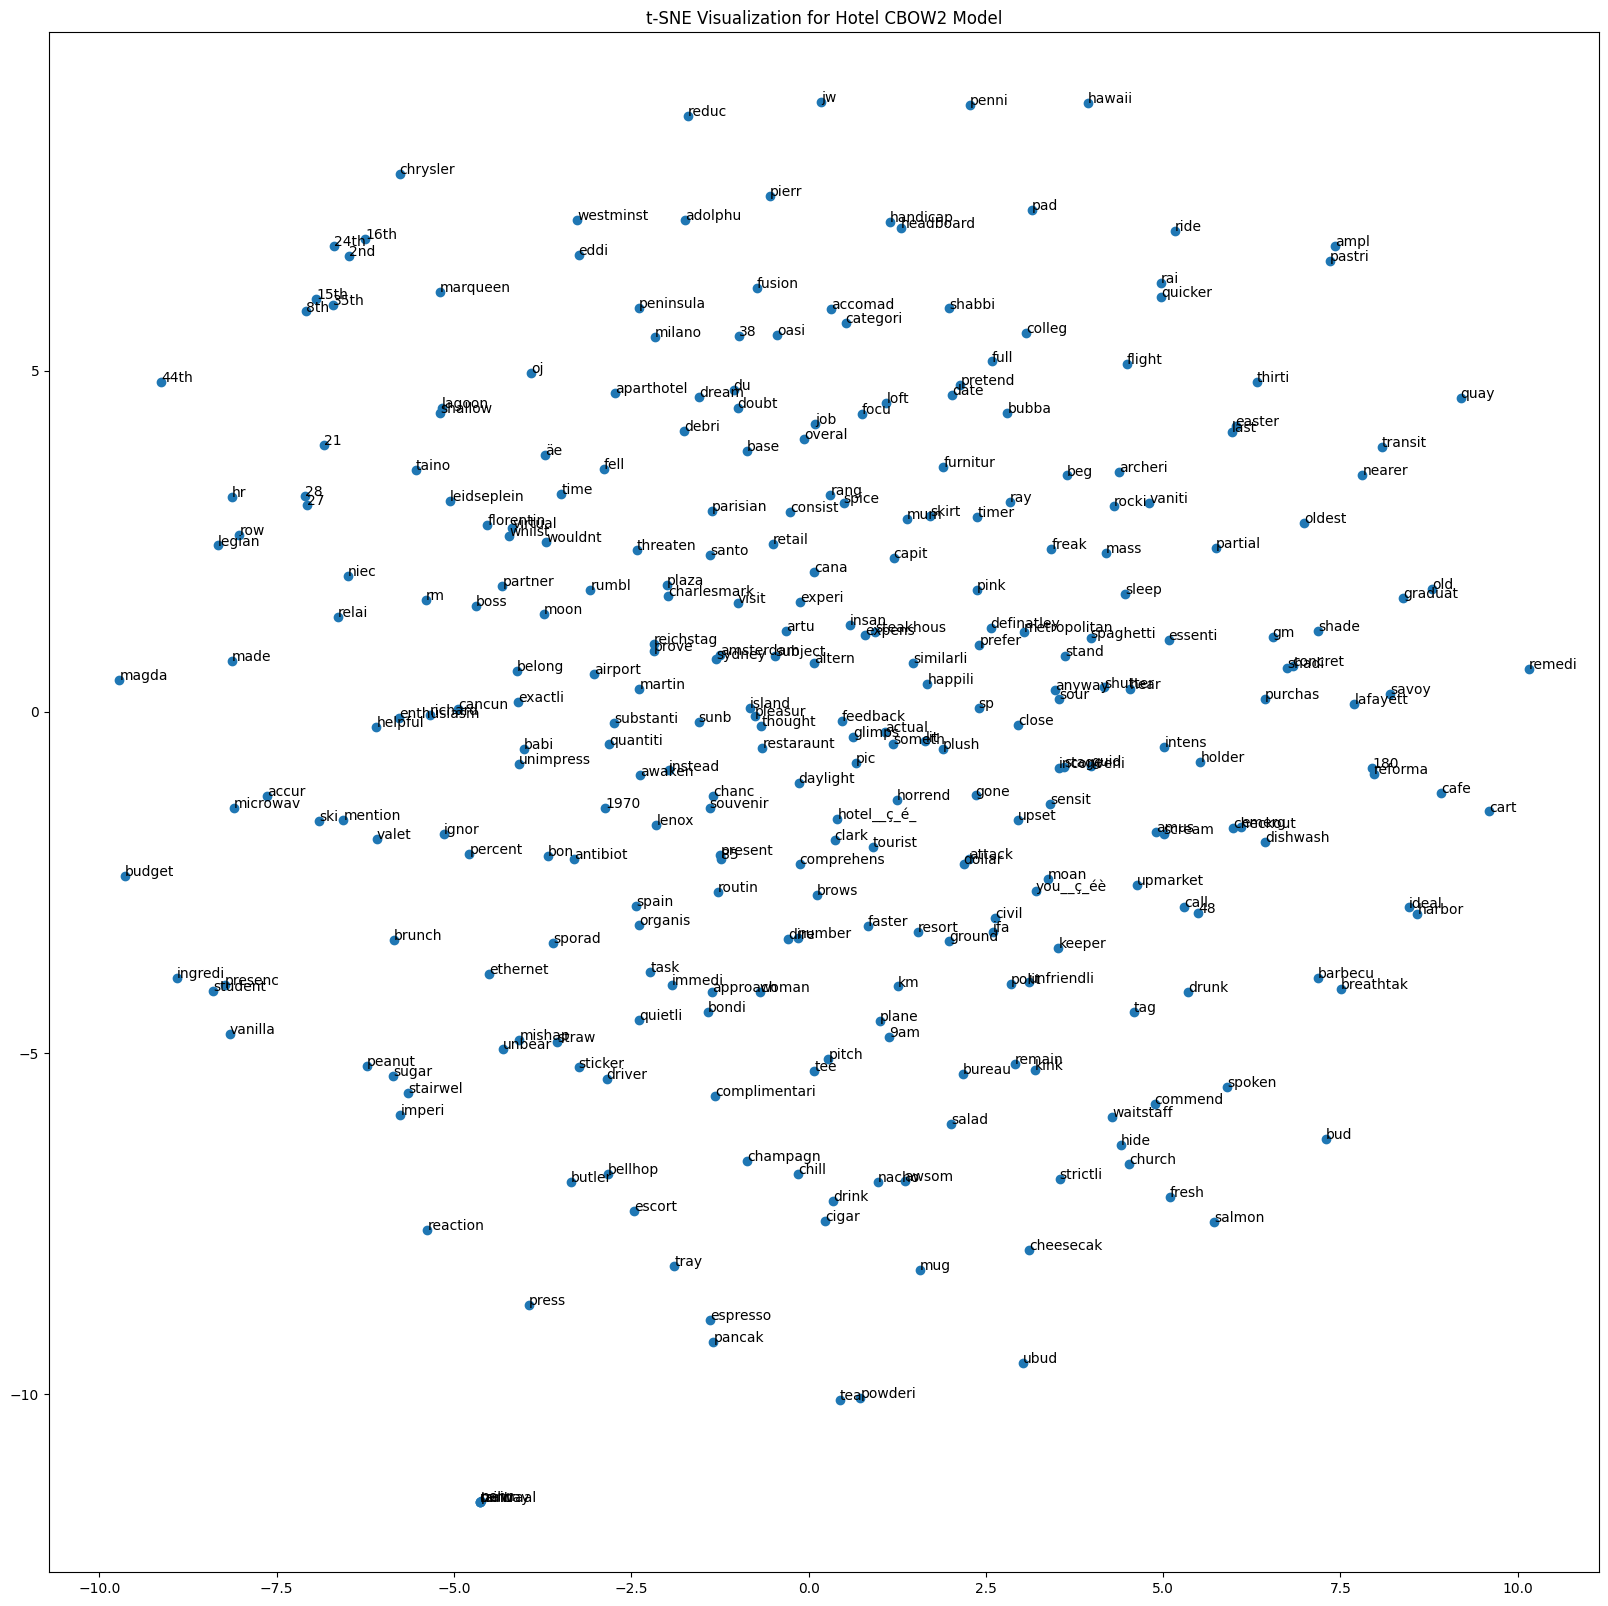

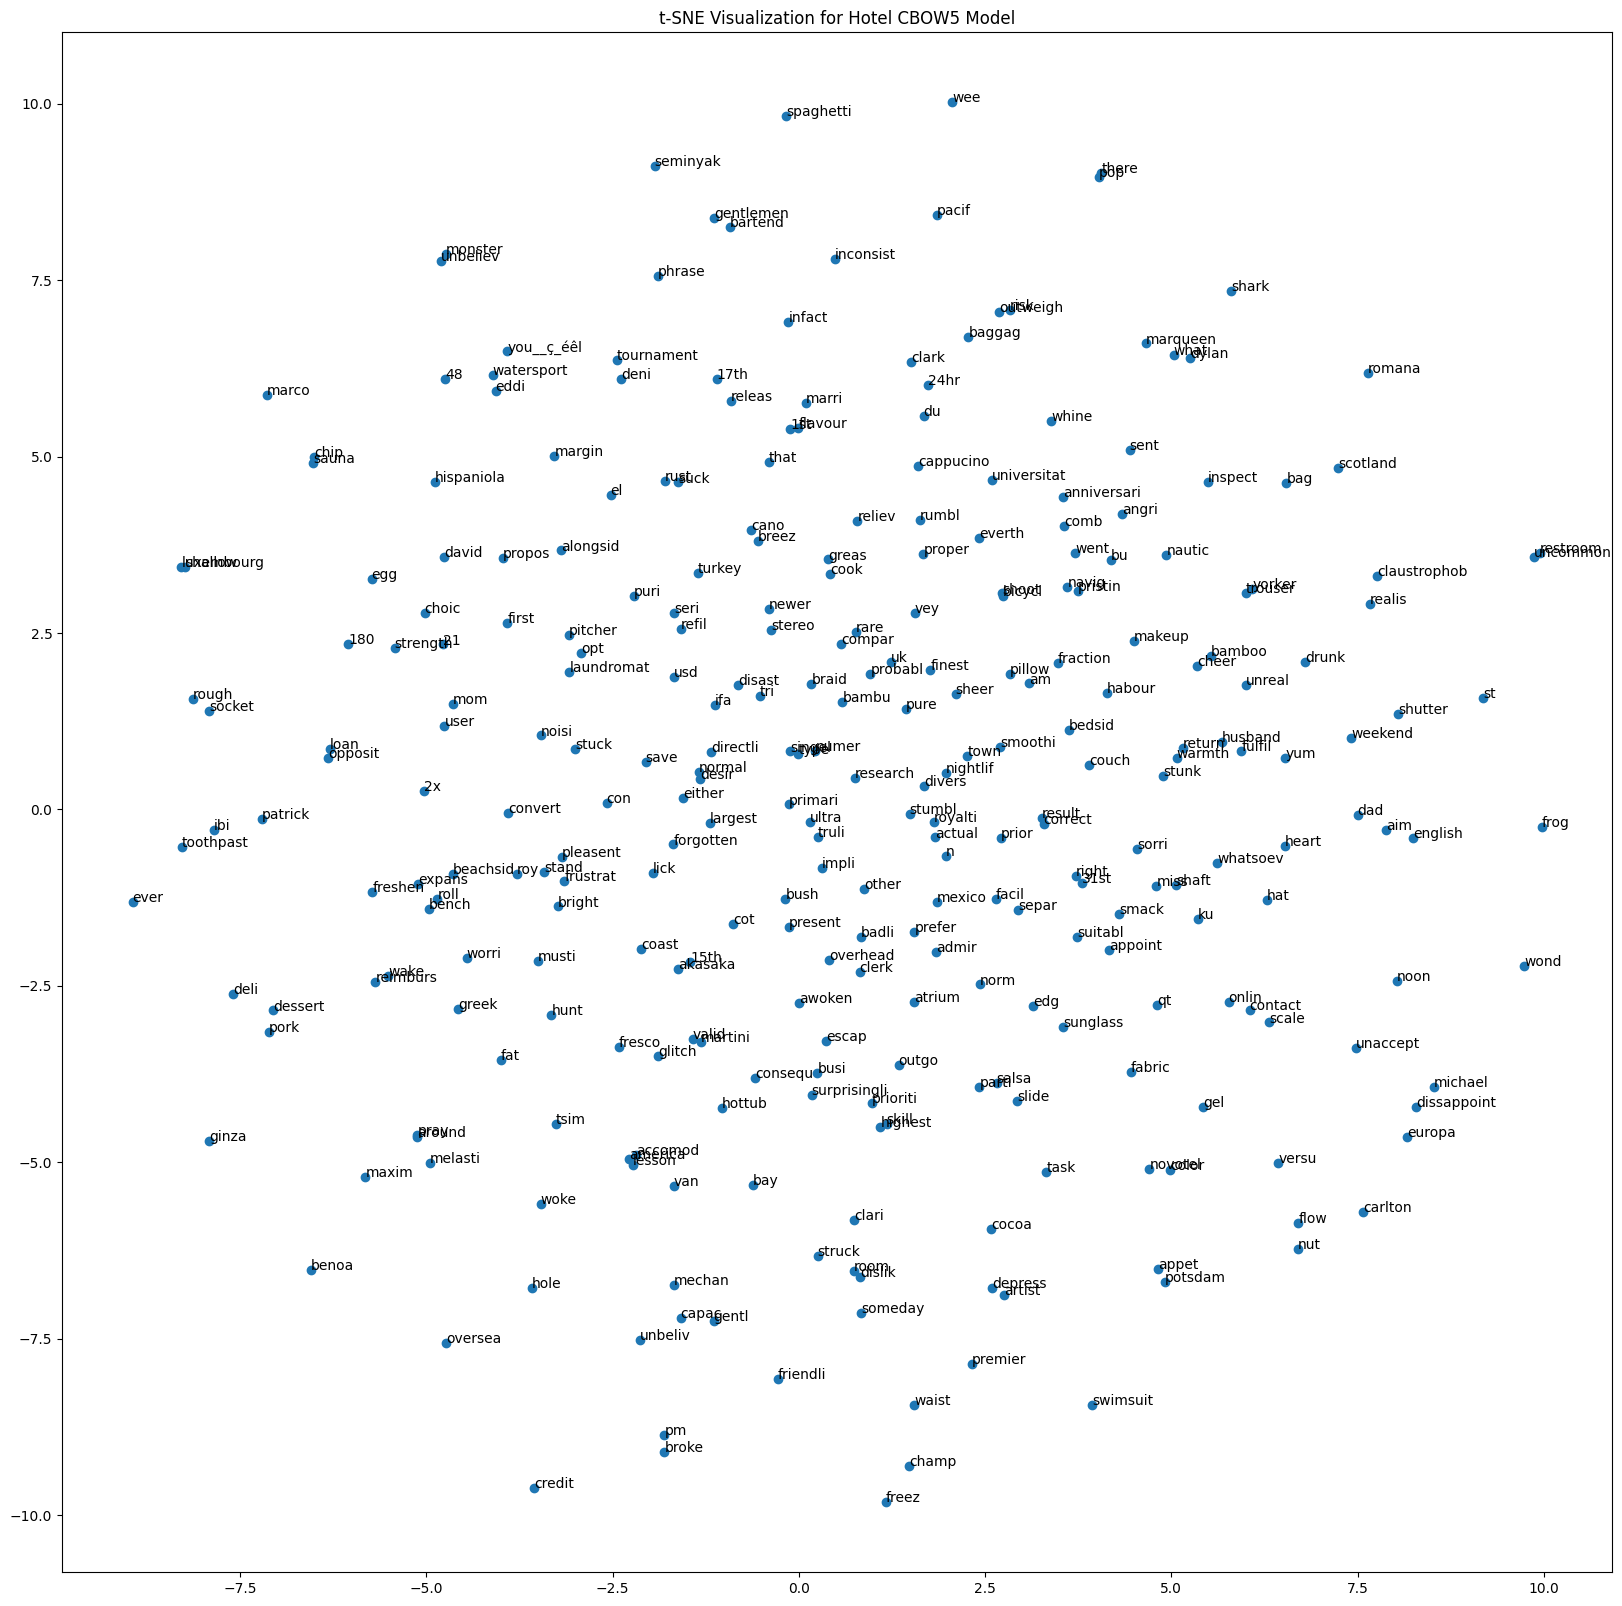

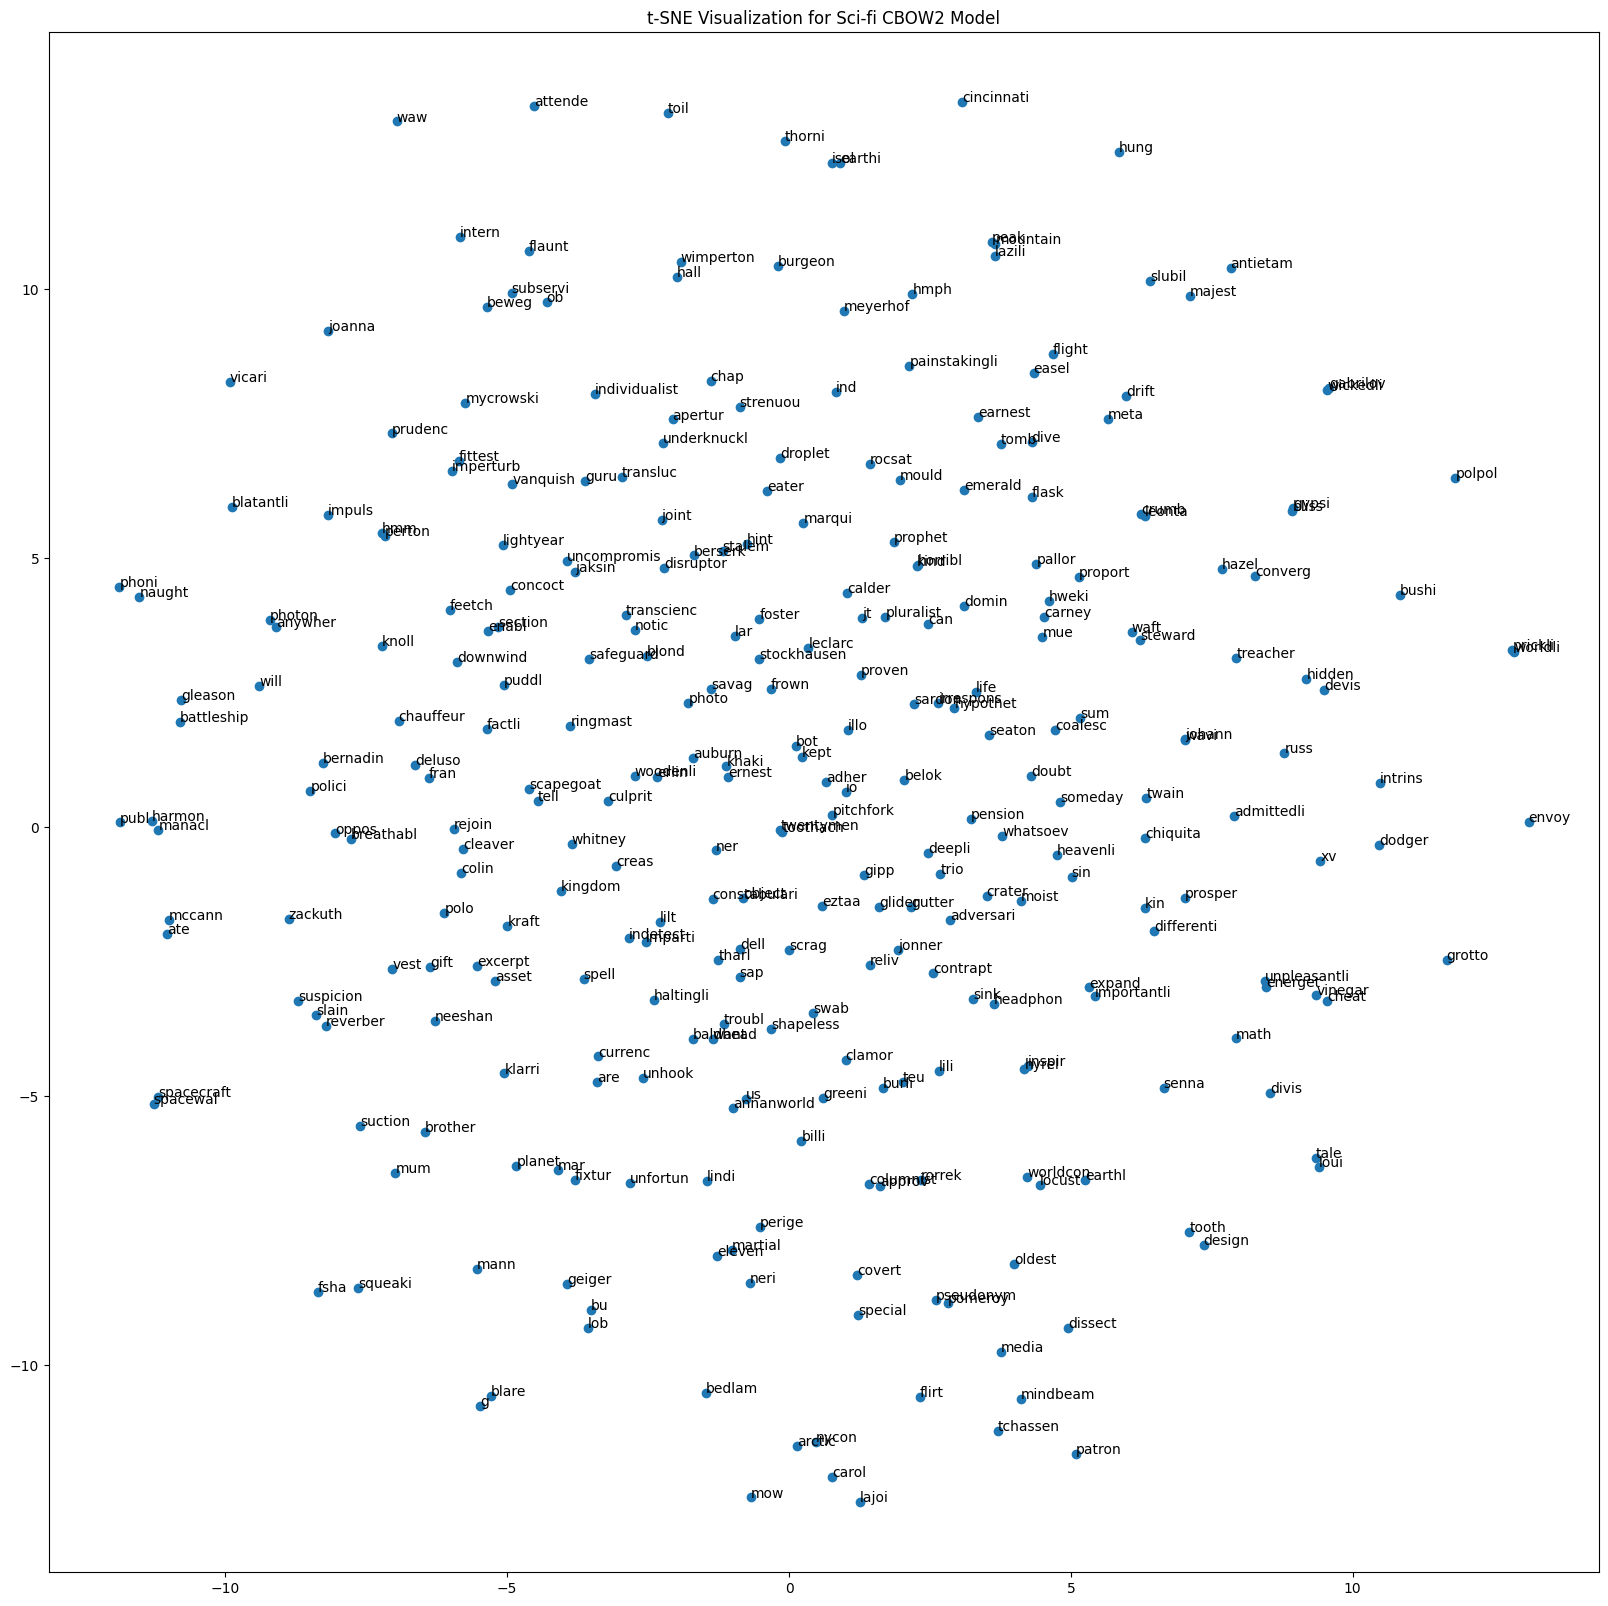

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# 6. What are the differences between CBOW2 and CBOW5 ? Can you "describe" them? --> Report
def visualize_em(model, w2i, sample_size=300, perplexity=20, title="t-SNE Visualization"):
    # Get the embeddings
    embeddings = model.embeddings.weight.data.cpu().numpy()

    # Select words
    indices = np.random.choice(len(w2i), sample_size, replace=False)
    embeddings_sample = embeddings[indices]
    words_sample = [list(w2i.keys())[list(w2i.values()).index(idx)] for idx in indices]

    # Dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=perplexity)
    reduced = tsne.fit_transform(embeddings_sample)

    # Visualization
    plt.figure(figsize=(20, 20))
    plt.scatter(reduced[:, 0], reduced[:, 1])
    for i, word in enumerate(words_sample):
        plt.annotate(word, (reduced[i, 0], reduced[i, 1]))
    plt.title(title)
    plt.show()

# Visualize
visualize_em(model_h2, w2i_h, title="t-SNE Visualization for Hotel CBOW2 Model")
visualize_em(model_h5, w2i_h, title="t-SNE Visualization for Hotel CBOW5 Model")
visualize_em(model_s2, w2i_s, title="t-SNE Visualization for Sci-fi CBOW2 Model")